<a href="https://colab.research.google.com/github/spectraldoy/MusicTransformerTensorFlow/blob/main/Music_Transformer_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### © Copyright 2021 Aditya Gomatam

Licensed under the Apache License, Version 2.0 (the "License");

# Music Transformer Model

___SpectralDoy, May 8 - Aug 26 2020___

This notebook builds and trains a Music Transformer decoder model to generate music, based off the description in Huang et. al, 2018 (https://arxiv.org/pdf/1809.04281.pdf), with inferences taken from Shaw et. al, 2018 (Self Attention with Relative Position Representations: https://arxiv.org/pdf/1803.02155.pdf) and Vaswani et. al, 2017 (Attention is All You Need: https://arxiv.org/pdf/1706.03762.pdf), as well as Jay Alammar's blog (http://jalammar.github.io), and using the data representation given by Oore, et. al 2018, (This time with Feeling: https://arxiv.org/pdf/1808.03715.pdf).

This project will utilize the TPU provided by Google Colab in order to train the model. However, the GPU or CPU can be used to test it.

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

PATH = "./private/path"

In [ ]:
# in order to be able to checkpoint while training, connect to GCS Bucket
from google.colab import auth
auth.authenticate_user()
!gcloud config set project-name
!gsutil acl ch -u service-495559152420@cloud-tpu.iam.gserviceaccount.com:WRITER gs://bucket

In [ ]:
# things to handle midi files
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2 # normal FluidSynth
!gsutil -q -m cp gs://magentadata/soundfonts/Yamaha-C5-Salamander-JNv5.1.sf2 /content/ # magenta fluidsynth
!pip install midi2audio
!pip install mido

In [ ]:
# normal imports
%matplotlib inline

import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt

import os
import math
import time
import random

%cd ./private/path
import transformerutil5 as tu
%cd ../../..

In [ ]:
# fancy imports
import mido
from midi2audio import FluidSynth
from IPython.display import Audio

In [ ]:
# set up tpu
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver=resolver)
tf.config.list_logical_devices('TPU')

In [ ]:
# tpu distribution strategy
strategy = tf.distribute.TPUStrategy(resolver)

## Setup Input Pipeline

Here we will prepare the input to load into the model. This means setting up the Dataset. A key aspect of this is that, while the first (n-1) tokens will be input to the model, it will be asked to predict the last (n-1) tokens. This property can be encoded into the Dataset to be able to make adequate batches.

Since the task at hand is generation, we can split the data into train / validation / test in an 8 / 1 / 1 ratio. During training, the validation data will be used to calculate metrics, while the test data will be used as priors for generation.

In [ ]:
MAX_LENGTH = 1921
MAX_REL_DIST = 1921

In [ ]:
data = np.load(PATH + 'maestro_data_1922.npy')

# using the ratio 8/1/1, split data into train, val and test
lth = data.shape[0]
train_len = round(lth * 0.8)
val_len = round(lth * 0.1)
test_len = round(lth * 0.1)

if train_len + val_len + test_len != lth:
  test_len += lth - (train_len + val_len + test_len)

train_data = data[:train_len]
val_data = data[train_len:val_len + train_len]
test_data = data[train_len + val_len:]

print(f"There are {lth} files in the data, {train_data.shape[0]} files in the train_data, "\
      f"\n{val_data.shape[0]} files in the validation data, and {test_data.shape[0]} files in the test data.")

There are 302731 files in the data, 242185 files in the train_data, 
30273 files in the validation data, and 30273 files in the test data.


Now create the datasets and batch the data.

In [ ]:
BUFFER_SIZE = 120000

GLOBAL_BATCH_SIZE = 48
per_replica_batch_size = GLOBAL_BATCH_SIZE // strategy.num_replicas_in_sync

train_ds = tf.data.Dataset.from_tensor_slices((train_data[:, 1:], train_data[:, :-1]))
# drop remainder to be able to distribute on the TPU
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
# prefetch makes fetching data faster
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) 

# distribute over TPUs
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)

num_train_batches = len(list(train_dist_ds))

print(f"There are {num_train_batches} train batches")

There are 5045 train batches


Here's what a batch of inputs and targets looks like. Notice how the input batch contains start tokens (414) but no end tokens, while the target batch contains no start tokens, but contains end tokens (415), and that all other intermediate tokens are the same in corresponding rows of the input and target batches.

In [ ]:
tar_batch, inp_batch = next(iter(train_dist_ds))
inp_batch, tar_batch

(PerReplica:{
   0: <tf.Tensor: shape=(6, 1921), dtype=int32, numpy=
 array([[414,  67, 259, ..., 382,  62, 382],
        [414, 382,  51, ..., 400,  40, 259],
        [414, 260, 382, ...,  78, 259, 391],
        [414, 382,  67, ..., 382,  77, 258],
        [414, 258, 382, ...,  75, 259, 382],
        [414, 261, 392, ...,  52, 382,  56]], dtype=int32)>,
   1: <tf.Tensor: shape=(6, 1921), dtype=int32, numpy=
 array([[414, 266, 382, ..., 391,  66, 264],
        [414,  75, 258, ..., 264, 382,  73],
        [414, 258, 394, ...,  54, 258, 396],
        [414, 258, 382, ...,  75, 261, 382],
        [414, 408,  45, ..., 399,  63, 398],
        [414,  74, 258, ..., 382,  87, 262]], dtype=int32)>,
   2: <tf.Tensor: shape=(6, 1921), dtype=int32, numpy=
 array([[414, 382,  86, ...,  90, 259, 382],
        [414,  47, 382, ...,  70, 260, 382],
        [414,  53, 263, ...,  51, 258, 382],
        [414,  68, 260, ..., 382,  52, 265],
        [414,  68, 382, ..., 395,  51, 260],
        [414, 402,  49, 

Now, the data has been batched and shuffled, ready to input to the model. However, before we can actually build and train the model, we have to define certain functionalities.

## Absolute Positional Encoding

Since the transformer does not use recurrence or convolution, we have to deliberately give it positional information. Though learned relative position embeddings will be added to the model, it is possible that absolute position encoding will aid it in predicting next tokens.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode position in the input sequence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning, as well as their position in the sentence, in this d-dimensional space - information which the transformer can use to better predict next tokens.

The formula for absolute position encoding is as follows:
$$\Large{PE_{(pos, 2k)} = sin(pos / 10000^{2k / d_{model}})} $$
$$\Large{PE_{(pos, 2k+1)} = cos(pos / 10000^{2k / d_{model}})} $$

In [ ]:
def get_angles(position, k, d_model):
  # all values of each k
  angle = 1 / np.power(10000, 2 * (k // 2) / d_model)
  # matrix multiplied into all positions - represent each position with a d_model sized vector
  return position @ angle

In [ ]:
def abs_positional_encoding(max_position, d_model, n=3):
  """
  returns absolute position encoding, creating a vector representation for all positions
  from 0 to max_position of shape (d_model,) -> a matrix of shape (max_position, d_model)
  and broadcasts it to n dimensions
  """
  # angles are of shape (positions, d_model)
  angles = get_angles(np.arange(max_position)[:, np.newaxis], 
                      np.arange(d_model)[np.newaxis, :], 
                      d_model)
  
  # apply sin to the even indices along the last axis
  angles[:, 0::2] = np.sin(angles[:, 0::2])

  # apply cos to the odd indices along the last axis
  angles[:, 1::2] = np.cos(angles[:, 1::2])

  # broadcast to n dimensions
  for _ in range(n - 2):
    angles = angles[np.newaxis, :]
  return tf.cast(angles, tf.float32)

(1, 50, 256)


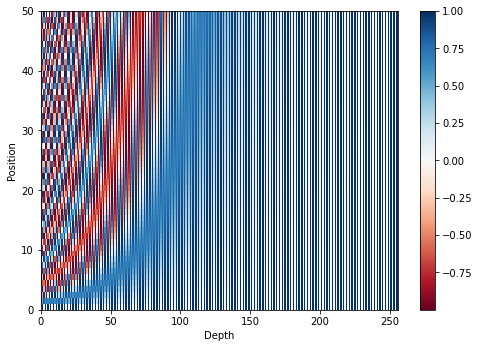

In [ ]:
pos_encoding = abs_positional_encoding(50, 256)
print (pos_encoding.shape)

fig = plt.figure(figsize=(8, 5.5))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()
del pos_encoding, fig

## Masking

Since some of the input sequences are padded with pad tokens (0), we need to mask out these parts of the input sequences so that the model does not treat it as input. The mask will be created as a tensor of the same shape as the input with ones in the positions that need to be masked.

However, the network will be dealing with 3-dimensional or 4-dimensional tensors, rather than a simple 2D embedded sequence. Thus, the shape of the mask must be made broadcastable to n dimensions.

In [ ]:
def create_padding_mask(seq, n=4):
  """
  Creates padding mask for a batch of sequences seq. Mask will be of shape
  (batch_size, seq_len), and can be broadcasted to n dimensions
  """
  mask = tf.cast(tf.equal(seq, 0), tf.float32) # mask is 1 where seq is 0
  # reshape to # batch_size, 1, ..., 1. seq_len
  return tf.reshape(mask, (tf.shape(mask)[0], *[1 for _ in range(n-2)], tf.shape(mask)[-1]))

In [ ]:
# for example
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x, n=3))
del x

tf.Tensor(
[[[0. 0. 1. 1. 0.]]

 [[0. 0. 0. 1. 1.]]

 [[1. 1. 1. 0. 0.]]], shape=(3, 1, 5), dtype=float32)


Additionally, in the calculation of Scaled Dot Product Attention, the transformer must be prevented from looking ahead at future tokens, so that the next outputs of the model are based only on the current and previous tokens in the input sequence.

This can be achieved by placing an upper triangular mask on the calculated Attention weights. Again, this will be 1 where the attention weights need to be zeroed, and zero otherwise. Unlike the case of the padding mask, where we need to know the values of the input sequences in order to create the mask, here the masking is the same for every input: an upper triangular matrix of ones of shape $(L, L)$ where $L$ is the length of the input sequence. We can create this just with $L$, without needing to input the sequence itself.

In [ ]:
def create_look_ahead_mask(seq_len):
  """
  Creates an upper triangular mask of ones of shape (seq_len seq_len).
  It is the same for all inputs of shape seq_len
  """
  mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  return tf.cast(mask, tf.float32) # (seq_len, seq_len)

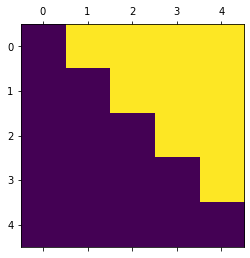

In [ ]:
# example
plt.matshow(create_look_ahead_mask(5))

At the stage when we need to input to the decoder, we have to create both a padding mask and a look ahead mask for the input batch. The correct final mask will be the maximum of these two, as the elements that need to be zeroed are represented by 1's, and those that need to be preserved are represented by 0's. 

In [ ]:
def create_mask(inp, n=4):
  """
  function to create the proper mask for an input batch
  mask = max(padding_mask, look_ahead_mask)

  Args:
    inp: batch tensor of input sequences of shape (..., seq_len)
  """
  padding_mask = create_padding_mask(inp, n)
  look_ahead_mask = create_look_ahead_mask(inp.shape[-1])

  # create final mask
  return tf.maximum(padding_mask, look_ahead_mask)

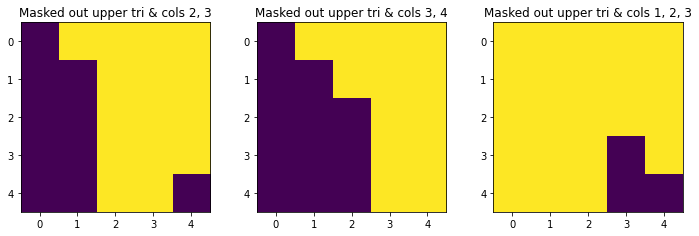

In [ ]:
# example: create a final decoder mask - columns of same indices where pad_mask is 1 are entirely masked
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

mask = create_mask(x, n=3)

fig = plt.figure(figsize=(10, 10))
rows = 1
cols = 3
labels = ["cols 2, 3", "cols 3, 4", "cols 1, 2, 3"]
for i in range(rows*cols):
  fig.add_subplot(rows, cols, i+1).set_title("Masked out upper tri & " + labels[i])
  plt.imshow(mask[i])
fig.tight_layout()
plt.show()
del x, mask, rows, cols, labels

The calculation of attention relies on a softmax of attention weights, and the elements of the attention weights that need to be zeroed are indicated by 1's in the mask. By adding the mask, scaled by an extremely low value such as -1e9 (to mimic -inf), to the attention weights logits, and then softmaxing this sum, the positions at which the mask was 1 will be effectively zeroed.

## Self-Attention with Relative Position Embeddings

A modification given by Shaw et. al, 2018, improved by Huang et. al, 2018, to the Scaled Dot-Product Attention mechanism given in Vaswani et. al, 2017, which allows the Transformer model to attend to all relevant elements of the input sequences as well as the relative distances between them.

$${\text{RelativeAttention} = \text{Softmax} \left(\frac{QK^\top + S^{rel}}{\sqrt{d_{k}}}\right)V}$$

Before attention can be computed, the input batch of sequences $X$ must be embedded to make it of shape $(..., L, d_{model})$, where $d_{model}$ is the size of the embeddings, from simply shape $(..., L)$. For attention to work properly, and for residual connections to be made conveniently, all inputs and outputs that the model deals with are associated with the shape $d_{model}$, which is why it is so named.

For instance, the first step in the computation of attention is to _transform_ the input $X$ into 3 representations - the queries($Q$), keys($K$) and values($V$):

$$Q = XW^Q$$
$$K = XW^K$$
$$V = XW^V$$

$Q$, $K$, and $V$ are all determined by the parameter matrices $W$, which are learned by backpropagation. In order to preserve the shape of $X$ (i.e., keep $Q, K, V$ all shaped $(..., L, d_{model})$), these $W$ must be of shape $(d_{model}, d_{model})$.

Now, the attention function in the transformer takes these three values - $Q$, $K$ and $V$ (and a last one, $E$) - as input. What we want the attention mechanism to achieve is to determines the "amount" of "attention" that each element in $X$ should pay attention to every other element in $X$ - that is, the importance of different positions of the sequence in constructing the sequence. This is achieved by the compatibility function $QK^\top + S^{rel}$.

Notice that $Q$ is of shape $(..., L, d_{model})$ and $K^\top$ is of shape $(..., d_{model}, L)$. As a result, the matrix product $QK^\top$ (and the additional relative position encoding $S^{rel}$) is of shape $(...,L, L)$. Given the goal of the attention mechanism, we would want the $i, j$ element of the output of the compatibility function to represent the amount of attention that the $ith$ element of the input sequence should pay to its $jth$ element. One can imagine that if $W^Q$ and $W^K$ were properly optimized by backpropagation, the representations of the input sequences in $Q$ by $XW^Q$ and in $K$ by $XW^K$ would be such that the matrix product $QK^\top$ achieves this goal. 

The softmax turns these compatibilities into probabilities (0 to 1), and it is the softmax of the compatibilities that is multipled by $V$. What does this achieve? Well, the compatibility matrix in itself is virtually useless. All it is is a lookup table of how important element $i$ is to element $j$. By multiplying this compatibility matrix by $V$, what we do is distribute this information about the attention that every element in the sequence should pay to every other element in the sequence into every element of a representation of the input sequence itself. What this also achieves, the softmaxed values being between 0 and 1, is the minimization of unimportant values, and the maximization of the most important ones.

However, without altering this configuration properly, elements of the compatibility matrix where $j>i$, would give the $ith$ position of the sequence information about a future position in the sequence, after which the model could simply learn to use this information in order to predict the future tokens, instead of paying attention to its previous and current inputs to do so. This is why the look_ahead_mask must be used on the compatibility matrix. All elements where $j>i$ are simply the upper triangle of the matrix, and so the look_ahead_mask is simply an upper triangular matrix of the same shape.

Lastly, the compatibility matrix is scaled by $1/\sqrt{d_{k}}$ before softmaxing, where $d_k$ is the length of the embeddings for each sequence in $K$ (i.e., shape of last axis), in order to counteract the problem of vanishing gradients when computing softmax (Vaswani et. al, 2017). 

But where does $E$ come into this, and what is $S^{rel}$?


### Skewing

While the computation of attention given in Vaswani et. al, 2017 is simply:

$${\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V}\tag{1}$$

Shaw et. al, 2018 proposed the addition of a $(..., L, L)$ tensor $S^{rel}$ to the calculation of the softmax logits (as well as to $V$, but we can ignore that one for reasons of space and time complexity) in order to inject information about the relative distances between positions in the sequence into the calculation of attention. One can imagine that without information about the importance of the positions itself, the model would learn how important each element is in the sequence, but not in relation to its actual position in the sequence. This is why positional encoding is necessary. 

The calculation of $S^{rel}$ was greatly improved on by Huang et. al, 2018:

$${S^{rel} = \text{skew}\left(QE^\top\right)}\tag{2}$$

$Q$ is our queries matrix $XW^Q$, but $E$ is more interesting. $E$ is a set of embeddings for each possible relative distance in the sequence from $-L_{max} + 1$ to 0 (where $L_{max}$ is a maximum relative distance to consider - this has to be predefined). 

As was stated before, in the computation of the attention logits (the compatibility matrix before being softmaxed), the $i, j$ element describes how much attention the $ith$ position of the sequence should pay to the $jth$ position of the sequence. If we were to inject information about relative position into this calculation with $S^{rel}$, we would therefore want the $i, j$ element of $S^{rel}$ to represent the importance of the relative distance $(j-i)$ for the $ith$ element of the sequence. 

The way we inject this information is by letting the Relative Position Embeddings $E$ interact with the Queries tensor $Q$, giving rise to a new tensor $S^{rel}$, and then simply adding this information to the vanilla attention logits $(QK^\top)$. 

Before this, however, we must slice the last $L$ embeddings from $E$ (the embeddings for relative distances of $-L+1$ to $0$) and to calculate the matrix product $QE^\top$, or if $L > L_{max}$ (i.e., the input sequence length is greater than the maximum relative distance to consider), we simply use the last relative position embedding (for a relative distance of $-L_{max}+1$) for all indices past this relative distance. This slice is necessary to preserve shape ($QE^\top$ will be of shape $(..., L, L)$, which is the same shape as $QK^\top$ and the two can simply be added). Additionally, what we get out of computing this matrix product is the product of every query $Q_i$ with every relative position embedding $E_j$, thus instantiating a tensor whose elements describe the importance of a relative distance of $j$ to the $ith$ element in the sequence.

However, simply now adding this matrix product $QE^\top$ to $QK^\top$ would not inject the correct relative position information at the required indices, because its $i, j$ element does not descibe the importance of a relative distance of $(j-i)$ to the $ith$ elemtn of the sequence.

How do we get around this? First, let's visualize the problem. Consider $E$ to be a set of embedding vectors $E_j$ of length $d_{model}$, ordered from $-L + 1$ to $0$, i.e., $E=(E_{-L+1}, E_{-L+2}, ..., E_0)$, and, for 1 sequence, consider the Queries matrix to be a set of $L$ vectors $Q_i$ each of length $d_{model}$, $Q=(Q_0, Q_1,...,Q_{L-1})$. Then, it is easy to see that the matrix product $QE^\top$ does not achieve the desired ordering, because the $i, j$ element of $QE^\top$ does not necessarily incorporate the embedding for a relative distance of $(j-i)$:

$$\begin{equation*}
\pmatrix{Q_0 \\ Q_1 \\ \vdots \\ Q_{L-2} \\ Q_{L-1}} \cdot
\pmatrix{E_{-L+1} & E_{-L+2} & \cdots & E_{-1} & E_0} =
\begin{pmatrix}
Q_0E_{-L+1} & Q_0E_{-L+2} & \cdots & Q_0E_{-1} & Q_0E_0 \\
Q_1E_{-L+1} & Q_1E_{-L+2} & \cdots & Q_1E_{-1} & Q_1E_0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
Q_{L-2}E_{-L+1} & Q_{L-2}E_{-L+2} & \cdots & Q_{L-2}E_{-1} & Q_{L-2}E_0 \\
Q_{L-1}E_{-L+1} & Q_{L-1}E_{-L+2} & \cdots & Q_{L-1}E_{-1} & Q_{L-1}E_0 \\
\end{pmatrix}
\end{equation*}$$

Nevertheless, this matrix contains all the information we need to inject this information correctly - every $Q_i$ multiplied by every $E_j$, and we just need to order it so that the $i, j$ element of the matrix is of the form $Q_iE_{j-i}$. Huang et. al, 2018 implemented the skewing algorithm to do this.

To understand skewing, imagine the desired ordering. In this ordering, the main diagonal would consist of $Q_iE_0$ - at the $i, i$ position of the matrix, the relative distance to be injected would be 0. Furthermore, along the diagonal just under the main diagonal - the $i, (i-1)$ elements of the matrix - all elements would be $Q_iE_{-1}$. As visible in the above matrix, these elements are given in the last 2 columns - the elements we want along the main diagonal are in the last column, and the elements we want along the diagonal just under it are in the first column from the last.

Nevertheless, although we have $L$ elements along the last column, which would fit the main diagonal, we also have $L$ elements in the first column from the last, which is one more than would fit the diagonal just under the main. Nevertheless, if we look closely, we see that we can exclude the first entry, $Q_0E_{-1}$, from this second-to-last column. This is because it has no meaning - the 0th element in the sequence does not have any previous elements, and so cannot have a relative distance of (-1) to any other element of the sequence. Similarly, the first two elements in the third-to-last column of $QE^\top$, where the queries are multiplied by $E_{-2}$ – $Q_0E_{-2}$ and $Q_1E_{-2}$ – can be ignored, because there are no elements in the sequence that are (-2) positions away from the 0th and 1st positions in the sequence. And so on, so that the last $L-n$ elements of the $nth$ column from the last can fit the $nth$ diagonal under the main.

Now, we know where the information we want is (the columns from the last in $QE^\top$), and we know where we want it to go to make $S^{rel}$ (the diagonals on and under the main). If we could just **skew** the elements of $QE^\top$ in the columns from the right into the desired diagonals, we would get $S^{rel}$, and we could just add it to $QK^\top$ in the calculation of the attention logits in order to properly encode relative position. And so, the skewing algorithm was made:
1. Pad $QE^\top$ with a dummy vector of length $L$ to the left
2. Reshape the matrix from shape $(..., L, L+1)$ to shape $(..., L+1, L)$
3. Slice the last $L$ rows from the second-to-last axis of this tensor - this is $S^{rel}$

So finally,

$${\text{RelativeAttention}(Q, K, V, E) = \text{Softmax} \left(\frac{QK^\top + \text{skew}\left(QE^\top\right)}{\sqrt{d_{k}}}\right)V}\tag{3}$$

Isn't that cool?

Another benefit of skewing is that once all the required elements are placed on or below the main diagonal in $\text{skew}(QE^\top)$, all irrelevant elements in the upper triangle will be masked out by the look_ahead_mask.


In [ ]:
def skew(t: tf.Tensor):
  """
  Implements skewing algorithm given by Huang et. al 2018 to reorder the
  dot(Q, RelativePositionEmbeddings) matrix into the correct ordering for which
  Tij = compatibility of ith query in Q with relative position (j - i)

  This implementation accounts for rank n tensors

  Algorithm:
      1. Pad T
      2. Reshape
      3. Slice

  T is supposed to be of shape (..., L, L), but the function generalizes to any shape
  """
  # pad the input tensor
  middle_paddings = [[0, 0] for _ in range(len(t.shape) - 1)]
  padded = tf.pad(t, [*middle_paddings, [1, 0]])

  # reshape
  Srel = tf.reshape(padded, (-1, t.shape[-1] + 1, t.shape[-2]))
  Srel = Srel[:, 1:] # slice required positions
  return tf.cast(tf.reshape(Srel, t.shape), t.dtype)

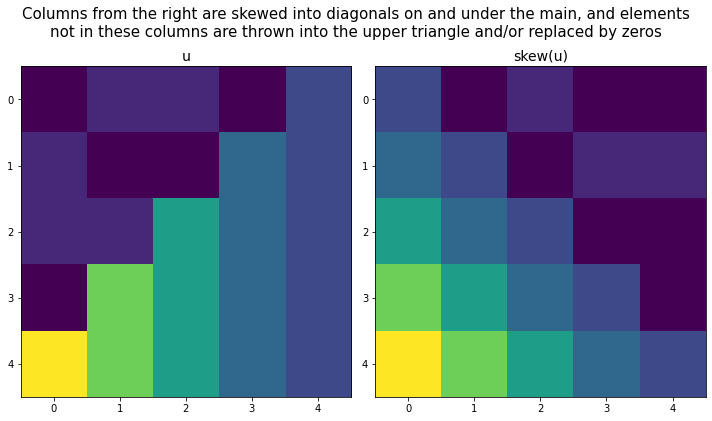

In [ ]:
# example
u = tf.constant([[0, 1, 1, 0, 2], \
                 [1, 0, 0, 3, 2], \
                 [1, 1, 5, 3, 2], \
                 [0, 7, 5, 3, 2], \
                 [9, 7, 5, 3, 2]], dtype=tf.float32)
plots = [u, skew(u)]
fig = plt.figure(figsize=(10, 6.5))
rows = 1
cols = 2
labels = ['u', 'skew(u)']
fig.suptitle("Columns from the right are skewed into diagonals on and under the main, and elements\n"\
             "not in these columns are thrown into the upper triangle and/or replaced by zeros", \
             fontsize=15) 
for i in range(rows*cols):
  fig.add_subplot(1, 2, i+1).set_title(labels[i], fontsize=14)
  plt.imshow(plots[i], cmap='viridis')
fig.tight_layout()
plt.show()
del u, plots, fig, rows, cols, labels

### Relative Scaled Dot Product Attention

Given the skewing algorithm, we can now define the Relative Attention function. This function is technically called Relative Scaled Dot Product Attention.

In [ ]:
def rel_scaled_dot_prod_attention(q, k, v, e, mask=None):
  """
  Implements equation 3 given in the previous section to calculate the attention weights,
  Mask has different shapes depending on its type (padding, look_ahead or combined),
  but by scaling and adding it to the attention logits, masking can be performed

  Attention = softmax(mask(QKT + skew(QET))/sqrt(d_k))V

  Args:
    q: Queries matrix of shape (..., seq_len_q, d_model)
    k: Keys matrix of shape (..., seq_len_k, d_model)
    v: Values matrix of shape (..., seq_len_k, d_model)
    e: Relative Position embedding matrix of shape (seq_len_k, d_model)
  
  Returns:
    output attention, attention weights
  """
  QKt = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)
  Srel = skew(tf.matmul(q, e, transpose_b=True)) # (..., seq_len_q, seq_len_k)

  # calculate and scale logits
  dk = math.sqrt(k.shape[-1])
  scaled_attention_logits = (QKt + Srel) / dk

  # add the mask to the attention logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e09) # mask is added only to attention logits
  
  # softmax is normalized on the last axis so that the ith row adds up to 1
  # this is best for multiplication by v because the last axis (made into 
  # probabilities) interacts with the values v
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v) # (..., seq_len_q, d_k)
  return output, attention_weights

As softmax is performed on the last axis of the attention weights, whose dimensions are determined by $K$, the values in the Keys determine the importance of each Query in $Q$.

The (softmaxed) attention weights being multiplied by $V$ to calculate the output ensures that the positions of the queries sequence that you want to focus on are kept, while those that are less important are zeroed out.

In [ ]:
# examples of attention
temp_k = tf.constant([[0, 0, 10], [0, 10, 0], [10, 0, 0], [10, 0, 0]], dtype=tf.float32)
temp_v = tf.constant([[4, 2, 1], [5, 6, 3], [7, 8, 10], [9, 12, 45]], dtype=tf.float32)
temp_e = tf.zeros_like(temp_k) #zero the relative position embeddings to demonstrate original attention

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
attn, attn_weights = rel_scaled_dot_prod_attention(temp_q, temp_k, temp_v, temp_e)
print("Attention weights are,")
print(attn_weights)
print("Output Attention is,")
print(attn)

Attention weights are,
tf.Tensor([[8.4332744e-26 1.0000000e+00 8.4332744e-26 8.4332744e-26]], shape=(1, 4), dtype=float32)
Output Attention is,
tf.Tensor([[5. 6. 3.]], shape=(1, 3), dtype=float32)


Notice that since ```temp_q``` corresponded to ```
temp_k[1]```, the attention weights are maximum at that index, and the output attention is that value in ```temp_v```. The query aligned with a specific key, and thus prioritized the corresponding value to pay attention to.

In [ ]:
# we should also see how relative position embeddings change the output
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) # aligns with second key

temp_e = tf.constant([[-1, -1, -10], [2, 2, 2], [1, 1, 1], [4, 4, 4]], dtype=tf.float32)

attn, attn_weights = rel_scaled_dot_prod_attention(temp_q, temp_k, temp_v, temp_e)
print("Attention weights are,")
print(attn_weights)
print("Output Attention is,")
print(attn)

Attention weights are,
tf.Tensor([[2.5339164e-33 1.0000000e+00 2.6217687e-28 8.7255939e-21]], shape=(1, 4), dtype=float32)
Output Attention is,
tf.Tensor([[5. 6. 3.]], shape=(1, 3), dtype=float32)


Above, we can see that since the query aligned with the second key, and since the highest embedding is that for relative distance of 0 (the very last embedding vector), this position was prioritized and the second value was output. However, changing ```temp_q``` to align with the first key:

In [ ]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)

temp_v = tf.constant([[4, 2, 1], [5, 6, 3], [7, 8, 10], [9, 12, 45]], dtype=tf.float32)
temp_e = tf.constant([[-1, -1, -10], [2, 2, 2], [1, 1, 1], [4, 4, 4]], dtype=tf.float32)

attn, attn_weights = rel_scaled_dot_prod_attention(temp_q, temp_k, temp_v, temp_e)
print("Attention weights are,")
print(attn_weights)
print("Output Attention is,")
print(attn)

Attention weights are,
tf.Tensor([[9.3410162e-11 9.6648464e-06 3.0046529e-08 9.9999034e-01]], shape=(1, 4), dtype=float32)
Output Attention is,
tf.Tensor([[ 8.999962 11.999942 44.999596]], shape=(1, 3), dtype=float32)


We see that even though the query aligned with the first key, the output attention is closer to the last value. This is because of the high embedding in the last index of ```temp_e```. Even though it corresponds to a relative distance of 0, the highest value in $S^{rel}$ is the matrix multiplication ```q @ temp_e[-1].transpose```, simply because of the value of that embedding. In order to get the desired output, we have to mask out those values.

In [ ]:
attn, attn_weights = rel_scaled_dot_prod_attention(temp_q, temp_k, temp_v, temp_e,\
                                                   mask=create_look_ahead_mask(temp_k.shape[-2])[0])
print("Attention weights are,")
print(attn_weights)
print("Output Attention is,")
print(attn)
del temp_k, temp_v, temp_e, temp_q, attn, attn_weights

Attention weights are,
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
Output Attention is,
tf.Tensor([[4. 2. 1.]], shape=(1, 3), dtype=float32)


And we get the first value, as desired. We can also play around with the embeddings to see how we can query one element to get a previous element, or an average of the current and previous elements, depending on the relative position embeddings:

In [ ]:
# play around with temp_q and temp_e
temp_k = tf.constant([[0, 0, 10], [0, 10, 0], [10, 0, 0], [0, 0, 510]], dtype=tf.float32)
temp_v = tf.constant([[4, 2, 1], [5, 6, 3], [7, 8, 10], [9, 12, 45]], dtype=tf.float32)

temp_q = temp_k

# highest embedding is for distance of -2, and second highest is for 0
# so for the first 2 values, the distance of -2 is masked out, and it outputs the 
# positions of relative distance 0
# but for the last 2, the values 2 positions behind are output
temp_e = tf.constant([[0, 0, 0], [1000000, 1000000, 1000000], [0, 0, 0], [100, 100, 100]], dtype=tf.float32)

attn, attn_weights = rel_scaled_dot_prod_attention(temp_q, temp_k, temp_v, temp_e,\
                                                   mask=create_look_ahead_mask(temp_k.shape[-2]))
print("Attention weights are,")
print(attn_weights)
print("Output Attention is,")
print(attn)
del temp_k, temp_v, temp_e, temp_q, attn, attn_weights

Attention weights are,
tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]], shape=(4, 4), dtype=float32)
Output Attention is,
tf.Tensor(
[[4. 2. 1.]
 [5. 6. 3.]
 [4. 2. 1.]
 [5. 6. 3.]], shape=(4, 3), dtype=float32)


In this way, the attention function is able to decide which values in the sequence to pay attention to in order to predict the next tokens, and is aided in this with the correct relative position embeddings.

### Multi-Head Attention

Instead of performing the attention on $d_{model}$-dimensional $Q$, $K$, and $V$, Vaswani et. al, 2017 found it beneficial to compute attention for these tensors along  $h$ different "heads." 

One can see why this is beneficial simply by looking at the matrix transformations that take place. First, $Q$, $K$, $V$ and $E$ are split to have different parts of their _embeddings_ (not different parts of the sequence) along $h$ different heads. In doing so, each head is given embeddings from each tensor of length $d_h$, where $d_h = \frac{d_{model}}{h}$:

$$\begin{matrix}
Q \\
K \\
V
\end{matrix} \Bigg\} \:\text{shape}(..., L, d_{model}) \rightarrow \text{shape}(..., h, L, d_h) $$

$E$ is also reshaped from $(L, d_{model})$ to $(h, L, d_h)$. 

Now, along each of these heads, we compute ```rel_scaled_dot_prod_attention```, and at each head, attention weights of shape $(..., L, L)$ are produced, due to the deliberate reshaping of the input tensors. That is, attention weights are calculated $h$ times (though with resolution downsampled from $d_{model}$ to $d_h$). This means that the model creates $h$ different representations of the amount of attention that each position in each input sequence should pay to every previous position in the sequence. This allows the network to attend to information from several different representations simultaneously, increasing accuracy, as well as making the calculation of attention slightly quicker by computing attention over $h$ smaller tensors in parallel.

After multiplication of the attention weights at each head by the $V$ tensor for that head, $V_i, i \in \{1...h\}$, $h$ tensors of shape $(..., L, d_h)$ are created for each sequence in the batch. They can then be concatenated back to a tensor of shape $(..., L, d_{model})$ to get back to the original shaping. Vaswani et. al, 2017 also project this Multi-Head Attention with a final parameter matrix $W^O$ of shape $(d_{model}, d_{model})$ to get the final output. Thus:

$$\text{MultiHeadRelativeAttention} = Concat\left(\text{head}_1, ..., \text{head}_h\right) W^O \\
\text{head}_i = \text{RelativeAttention}(Q_i, K_i, V_i, E_i)$$

As was stated earlier, $Q$, $K$, and $V$ are computed from $X$, the input batch of sequences. We can encode this calculation, as well as the instantiation and use of the Relative Position Embedding Matrix, $E$, into the ```MultiHeadAttention``` block. But first, we must define some helper functions.

In [ ]:
# helper function
def split_heads(x, num_heads, depth=None):
  """
  assumes x is of shape (..., num_heads * depth)
  split the last dimension of x into (num_heads, depth),
  transposes to (..., num_heads, L, depth)
  """
  if depth is None:
    assert x.shape[-1] % num_heads == 0
    depth = x.shape[-1] // num_heads

  # split d_model into h, d_h
  x = tf.reshape(x, (*x.shape[:-1], num_heads, depth)) # (..., L, num_heads, depth)

  # transpose axes -2 and -3 - tf specifies this with perm so all this fluff needs to be done
  final_perm = len(x.shape) - 1
  prior_perms = np.arange(0, final_perm - 2) # axes before the ones that need to be transposed

  # transpose to shape (..., num_heads, L, depth)
  return tf.transpose(x, perm=[*prior_perms, final_perm-1, final_perm-2, final_perm]) 

In [ ]:
# test
t = tf.random.normal((64, 10, 200))
print(split_heads(t, 8, 25).shape)
del t

(64, 8, 10, 25)


In [ ]:
# another helper function
def get_required_embeddings(E, seq_len, max_len=None):
  """
  Given an input sequence of length seq_len, which does not necessary equal max_len, the 
  maximum relative distance the model is set to handle, embeddings in E from the right are 
  the required relative positional embeddings
  Embeddings have to be taken from the right because E is considered to be 
  ordered from -max_len + 1 to 0
  For all positions distanced past -max_len + 1, use E_{-max_len + 1}
  """
  if not E.built:
    E.build(seq_len)
  if max_len is None:
    max_len = E.embeddings.get_shape()[0] # assumes E is a keras.layers.Embedding
  
  if max_len >= seq_len:
    seq_len = min(seq_len, max_len)
    return E(np.arange(max_len - seq_len, max_len))
  
  return tf.concat(
      values=[*[E(np.arange(0, 1)) for _ in range(seq_len - max_len)], E(np.arange(0, max_len))], 
      axis=0
  )

In [ ]:
# test
E = tf.keras.layers.Embedding(400, 200)
print(get_required_embeddings(E, 500).shape)
del E

(500, 200)


Now we can define the ```MultiHeadAttention``` block.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, max_rel_dist=MAX_REL_DIST, use_bias=True):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    self.max_len = max_rel_dist

    assert d_model % num_heads == 0, "d_model must be divisible into num_heads"

    self.depth = self.d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model, use_bias=use_bias) # parameter matrix to generate Q from input
    self.wk = tf.keras.layers.Dense(d_model, use_bias=use_bias) # parameter matrix to generate K from input
    self.wv = tf.keras.layers.Dense(d_model, use_bias=use_bias) # parameter matrix to generate V from input

    self.E = tf.keras.layers.Embedding(self.max_len, self.d_model) # relative position embeddings

    self.wo = tf.keras.layers.Dense(d_model, use_bias=use_bias) # final output parameter matrix
 
  def call(self, q, k, v, mask=None):
    """
    Creates Q, K, and V, gets required embeddings in E, splits into heads,
    computes attention, concatenates, and passes through final output layer
    """
    # Get Q, K, V
    q = self.wq(q) # (batch_size, seq_len, d_model)
    k = self.wk(k) # (batch_size, seq_len, d_model)
    v = self.wv(v) # (batch_size, seq_len, d_model)
    
    # Get E
    seq_len_k = k.shape[-2]
    e = get_required_embeddings(self.E, seq_len_k, self.max_len) # (seq_len_k, d_model)

    # split into heads
    q = split_heads(q, self.num_heads, self.depth) # (batch_size, h, seq_len_q, depth)
    k = split_heads(k, self.num_heads, self.depth) # (batch_size, h, seq_len_k, depth)
    v = split_heads(v, self.num_heads, self.depth) # (batch_size, h, seq_len_k, depth)
    e = split_heads(e, self.num_heads, self.depth) # (            h, seq_len_k, depth)

    # rel_scaled_attention shape = (batch_size, h, seq_len_q, depth)
    # attention_weights shape = (batch_size, h, seq_len_q, seq_len_k)
    rel_scaled_attention, attention_weights = rel_scaled_dot_prod_attention(q, k, v, e, mask=mask)

    # transpose rel_scaled_attention back to (batch_size seq_len_q, h, depth)
    final_perm = len(rel_scaled_attention.shape) - 1 # can't use rank for some reason
    prior_perms = np.arange(0, final_perm - 2) # axes before the ones that need to be transposed
    rel_scaled_attention = tf.transpose(rel_scaled_attention,
                                        perm=[*prior_perms, final_perm-1, final_perm-2, final_perm])

    # concatenate heads -> (batch_size, seq_len, d_model)
    sh = rel_scaled_attention.shape
    concat_attention = tf.reshape(rel_scaled_attention, (*sh[:-2], self.d_model)) 

    output = self.wo(concat_attention)

    return output, attention_weights

In [ ]:
# Create a MultiHeadAttention Block to test
t = tf.random.uniform((10, 1500, 256))
mha = MultiHeadAttention(256, 8, use_bias=True)
out, attn = mha(t, t, t, create_mask(tf.random.uniform((10, 1500))))

print(f"Shape of the output: {out.shape}")
print(f"Shape of the attention weights: {attn.shape}")
print(f"Number of trainable variables in the MHA block: {len(mha.trainable_variables)}")
del t, mha, out, attn

Shape of the output: (10, 1500, 256)
Shape of the attention weights: (10, 8, 1500, 1500)
Number of trainable variables in the MHA block: 9


Now that we've defined the core mechanism behind the transformer, we can move on to other layers and actually building the model.

## Pointwise Feed Forward Network

In each layer of the Transformer Decoder, the Multi-Head Attention block is followed by a fully-connected Feed Foward Network, which is simply a 2 layer network with a ReLU activation in between. 

In [ ]:
class PointwiseFFN(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, use_bias=True):
    super(PointwiseFFN, self).__init__()

    self.main = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu', use_bias=use_bias), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model, use_bias=use_bias) # (batch_size, seq_len, d_model)           
    ])
  
  def call(self, x):
    return self.main(x)

In [ ]:
# test it out
test_ffn = PointwiseFFN(512, 2048, True)
print(f"Shape of the output: {test_ffn(tf.random.uniform((60, 24, 512))).shape}")
print(f"Number of trainable variables in the FFN sublayer: {len(list(test_ffn.trainable_variables))}")
del test_ffn

Shape of the output: (60, 24, 512)
Number of trainable variables in the FFN sublayer: 4


## Decoder Layer

While the original Transformer consisted of an Encoder and a Decoder designed for seq2seq tasks, the Transformer Decoder Model was adapted to handle sequence generation. While every Encoder Layer in the original Transformer had 2 sublayers, and every Decoder Layer had 3 sublayers, the Transformer Decoder model, as adapted by Radford et. al, 2019 and others before (such as Liu, et. al, 2018: https://arxiv.org/pdf/1801.10198.pdf), scrapped the Encoder, and consisted solely of a stack of Decoder Layers, each with 2 sublayers:
1. Masked Multi-Head Attention
2. Pointwise Feed Forward Layer

Each sublayer also employs a residual connection followed by a LayerNorm on the last axis.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, max_rel_dist=MAX_REL_DIST, 
               use_bias=True, dropout=0.1, layernorm_eps=1e-06):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads, max_rel_dist=max_rel_dist, use_bias=use_bias)
    self.ffn = PointwiseFFN(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=layernorm_eps)
    self.layernorm2 = tf.keras.layers.LayerNormalization(axis=-1, epsilon=layernorm_eps)

    self.dropout1 = tf.keras.layers.Dropout(dropout)
    self.dropout2 = tf.keras.layers.Dropout(dropout)
  
  def call(self, x, training=False, mask=None):
    attn_output, attn_weights = self.mha(x, x, x, mask=mask) # calculate attention
    attn_output = self.dropout1(attn_output, training=training) # dropout
    # layernorm on residual connection
    out1 = self.layernorm1(x + attn_output) # (batch_size, seq_len, d_model)

    ffn_output = self.ffn(out1) # pass through FFN
    ffn_output = self.dropout2(ffn_output, training=training) # dropout
    # layernorm on residual connection
    out2 = self.layernorm2(out1 + ffn_output) # (batch_size, seq_len, d_model)

    return out2, attn_weights

In [ ]:
# test Decoder Layer
t = tf.random.uniform((32, 1500, 256))

sample_decoder_layer = DecoderLayer(256, 8, 1024)
out, attn = sample_decoder_layer(t, mask=create_look_ahead_mask(t.shape[-2]))

print(f"Shape of the output: {out.shape}")
print(f"Shape of the attention weights: {attn.shape}")
print(f"Number of trainable variables in Decoder Layer: {len(list(sample_decoder_layer.trainable_variables))}")
del t, out, sample_decoder_layer, attn

Shape of the output: (32, 1500, 256)
Shape of the attention weights: (32, 8, 1500, 1500)
Number of trainable variables in Decoder Layer: 17


## Transformer Decoder

Now that we have defined the Decoder Layer, we can build the Transformer Decoder as a stack of N decoder layers, along with the functionality to deal with an input sequence of tokens.

The Transformer Decoder consists of:
1. Input Embedding
2. N Decoder Layers
3. Final Linear Layer

The Input Embedding is the embeddings of size ```vocab_size``` for the input sequence. After the input embedding, absolute position encoding is added. The embedded input sequences are passed into the stack of decoder layers, and the output of that stack is passed into the Final Linear layer to take the decoder output from shape $(..., L, d_{model})$ to ($..., L$, ```vocab_size```). This final layer can be the original input embedding weight matrix, as per Press and Wolf, 2016, (https://arxiv.org/pdf/1608.05859.pdf), as the input and output are from the same vocabulary, or it can be a new Dense layer altogether.

In [ ]:
class TransformerDecoder(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, max_rel_dist=MAX_REL_DIST, 
               max_abs_position=20000, use_bias=True, dropout=0.1, layernorm_eps=1e-06, tie_emb=False):
    super(TransformerDecoder, self).__init__()

    self.num_layers = num_layers
    self.d_model = d_model
    self.tie_emb = tie_emb
    self.le = layernorm_eps

    self.max_position = max_abs_position # might need for decode

    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model) # input embeddings
    self.positional_encoding = abs_positional_encoding(max_abs_position, d_model) # absolute position encoding
    self.dropout = tf.keras.layers.Dropout(dropout) # embedding dropout

    # decoder layers
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, max_rel_dist, use_bias, dropout, layernorm_eps)\
                       for _ in range(self.num_layers)]

    # final layer is linear or embedding weight depending on tie emb
    if not tie_emb:
      self.final_layer = tf.keras.layers.Dense(vocab_size, use_bias=use_bias)
  
  def call(self, x, training=False, mask=None):
    # initialize attention weights dict to output
    attention_weights = {}

    # embed x and add absolute positional encoding
    x = self.embedding(x) # (batch_size, seq_len) -> (batch_size, seq_len, d_model)
    x *= math.sqrt(self.d_model) 
    if self.max_position > 0:
      x += self.positional_encoding[:, :x.shape[-2], :]

    x = self.dropout(x, training=training)

    # pass through decoder layers
    for i in range(len(self.dec_layers)):
      x, w_attn = self.dec_layers[i](x, training, mask)
      attention_weights[f'DecoderLayer{i+1}'] = w_attn
    
    # final layer
    if self.tie_emb:
      x = tf.matmul(x, self.embedding.embeddings, transpose_b=True)
    else:
      x = self.final_layer(x)
    
    # returns unsoftmaxed logits
    return x, attention_weights

In [ ]:
# example transformer
with strategy.scope():
  sample_transformer = TransformerDecoder(
      num_layers=6, d_model=256, num_heads=8, dff=1024, vocab_size=tu.vocab_size, max_rel_dist=1537, 
      max_abs_position=20000, use_bias=True, dropout=0.1, tie_emb=True
  )
out, attn = sample_transformer(tf.random.uniform((16, 1600))) # build the model
start = time.time()
out, attn = sample_transformer(tf.random.uniform((16, 1600), minval=0, maxval=400, dtype=tf.int32))
print(f"Shape of the output: {out.shape}")
print(f"Shape of the attention weights: {attn['DecoderLayer1'].shape}")
print(f"Number of parameters in the Tranformer Decoder: {len(list(sample_transformer.trainable_variables))}")
print(f"Time taken to compute over an input batch when not training: {time.time()-start} seconds")
del out, attn, sample_transformer, start

Shape of the output: (16, 1600, 416)
Shape of the attention weights: (16, 8, 1600, 1600)
Number of parameters in the Tranformer Decoder: 103
Time taken to compute over an input batch when not training: 4.357294797897339 seconds


# Training

## Set Hyperparameters

Sadly, the TPU can only compute loss on an input batch of batch size 48 and sequence length ~2000 tokens without crashing. The reference paper Huang et. al, 2018 does not specify the batch size but specifies the sequences trained on were of length 2048 tokens. 

While the batch size and sequence length cannot be changed, other relevant hyperparameters need to be experimented with to get the best results.

In [ ]:
num_layers = 6
d_model = 256
dff = 1024
num_heads = 8

max_rel_dist = MAX_REL_DIST
max_abs_position = 1

use_bias = True
tie_emb = False
layernorm_eps = 1e-06

vocab_size = tu.vocab_size # don't change this
dropout_rate = 0.1

## Learning Rate Schedule

As per Vaswani et. al, 2017, the Adam optimizer with a custom learning rate scheduler is used when training the transformer model:

$$lr = d_{model}^{\:-0.5} \cdot \min{\left(step\_num^{-0.5}, step\_num \:\cdot warmup\_steps^{-1.5} \right)}$$

Additionally, the betas to be used in the Adam optimizer are 0.9 and 0.98, with epsilon equal to 1e-9.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# how to set up the optimizer
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-09)
del learning_rate, optimizer

Text(0.5, 0, 'Train Step')

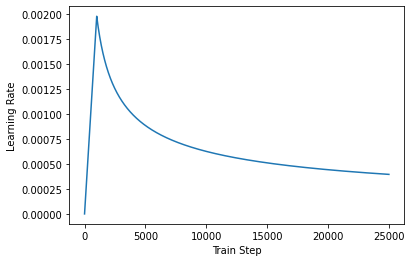

In [ ]:
plt.plot(CustomSchedule(256)(tf.range(25000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and Metrics

Since some of the inputs are padded, it is important to apply a padding mask when calculating the loss.

The loss object will be Sparse Categorical Entropy Loss. This is the loss to be used when dealing with indices in a vocabulary, rather than one-hot vectors.

In [ ]:
with strategy.scope():
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE
  )
  def loss_function(target, predictions, criterion=loss_object):
    """
    If defining custom criterion, make sure reduction is none
    """
    mask = tf.not_equal(target, tf.zeros_like(target))
    _loss = criterion(target, predictions)

    mask = tf.cast(mask, _loss.dtype) # make mask of same dtype as loss
    _loss *= mask

    return tf.reduce_sum(_loss) / tf.reduce_sum(mask)

In [ ]:
with strategy.scope():
  train_loss = tf.keras.metrics.Mean(name='train_loss') 
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  val_loss = tf.keras.metrics.Mean(name='val loss')
  val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val accuracy')

## Training and Checkpointing

The transformer is an autoregressive model, which means that at the inference stage, it will make next predictions based on its previous outputs.

However, while training, we can use teacher forcing - feeding the target into the model as previous output regardless of the true output of the model. This significantly cuts down on the compute required, while usually reducing loss (at the expense of generalizability, nonetheless).

Since we are training a generative model, the targets are simply the inputs shifted right by 1 position. The data has already been cut this way during the Input Pipeline.

Now, we need to create the model and optimizer, set up the checkpointing mechanism on a GCS Bucket, and train.

In [ ]:
# set before training
num_train_steps = 1000000
epochs = tf.convert_to_tensor(math.ceil(num_train_steps / num_train_batches))
print(epochs)

tf.Tensor(207, shape=(), dtype=int32)


Create the model and optimizer and the epoch from which to start training.

In [ ]:
with strategy.scope():
  transformer = TransformerDecoder(
      num_layers, d_model, num_heads, dff, vocab_size, MAX_REL_DIST, max_abs_position,
      use_bias, dropout_rate, layernorm_eps, tie_emb
  )
  learning_rate = CustomSchedule(d_model, warmup_steps=4000)

  optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                       epsilon=1e-09)
  
  start_epoch = tf.Variable(0) # to handle restarting training from a checkpoint

Now, since we'll have to train for a while, we'll use checkpoints to train the model. Every ```ckpt_interval``` epochs, we'll save the model weights, the optimizer state and the epoch number. 

In [ ]:
# build the. model
with strategy.scope():
  _ = transformer(tf.random.uniform((GLOBAL_BATCH_SIZE, MAX_LENGTH)))
  del _

In [ ]:
# set up the checkpoints
checkpoint_path = "checkpoint/path/in/bucket"
ckpt_interval = 1 # checkpoint every ckpt_interval epochs

with strategy.scope():
  checkpoint = tf.train.Checkpoint(transformer=transformer,
                                   optimizer=optimizer,
                                   epoch=start_epoch)
  
  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, 
                                            max_to_keep=5)

  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored.')
    print(f'Training will resume from epoch {start_epoch.numpy()}.')
    print(f'{optimizer.iterations.numpy()} train steps have already been completed.')

Latest checkpoint restored.
Training will resume from epoch 199.
966480 train steps have already been completed.


Now, to train!

In [ ]:
# define the train step and validation step functions
def train_step(target, inputs):
  # forward pass
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inputs, training=True, mask=create_mask(inputs))
    loss = loss_function(target, predictions) #/ (MAX_LENGTH)
  
  # update weights
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  # accuracy
  train_accuracy(target, predictions)
  train_loss(loss)
  return loss

def val_step(target, inputs):
  # forward pass
  predictions, _ = transformer(inputs, training=True, mask=create_mask(inputs))
  loss = loss_function(target, predictions) #/ (MAX_LENGTH)

  # accuracy
  val_accuracy(target, predictions)
  val_loss(loss)

  return loss

Since the step functions return the loss computed at each TPU core, we need to reduce the distributed loss back into one value.

In [ ]:
# distributed steps
@tf.function
def distributed_train_step(dataset_inp):
  per_replica_losses = strategy.run(train_step, args=(dataset_inp))
  final_loss =  strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

  # get metrics
  train_loss(final_loss)

  return final_loss

@tf.function
def distributed_val_step(dataset_inp):
  per_replica_losses = strategy.run(val_step, args=(dataset_inp))
  final_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

  # get metrics
  val_loss(final_loss)

  return final_loss

Finally, the training loop!

In [ ]:
# train loop
try:
  for epoch in range(start_epoch.numpy(), epochs):
    start = time.time()
    batch_timer = time.time()
    
    # train steps
    train_loss.reset_states()
    train_accuracy.reset_states()

    for batch, ds_inp in enumerate(train_dist_ds):
      distributed_train_step(ds_inp)

      if (batch + 1) % 202 == 0 or batch == 0:
        print(f"Processing Epoch {epoch} Train Batch {batch} " \
              f"Loss {round(train_loss.result().numpy().item(), 6)} " \
              f"Accuracy {round(train_accuracy.result().numpy().item(), 6)} " \
              f"Time taken {round(time.time() - batch_timer, 2)} secs")
        batch_timer = time.time()
    
    batch_timer = time.time()
    
    if (epoch + 1) % ckpt_interval == 0:
      start_epoch.assign(epoch + 1)
      print("Checkpointing...", end="")
      save_path = ckpt_manager.save()
      print(f"Done! Saved at {save_path}")

    print(f"Epoch {epoch} "\
          f"Train Loss {round(train_loss.result().numpy().item(), 6)} " \
          f"Train Accuracy {round(train_accuracy.result().numpy().item(), 6)}", end=" ")
    print(f"Val Loss {round(val_loss.result().numpy().item(), 6)} "\
          f"Val Accuracy {round(val_accuracy.result().numpy().item(), 6)}")
    print(f"Time taken for 1 epoch {round(time.time() - start, 2)} secs\n")

except KeyboardInterrupt:
  print("\nKeyboard Interrupt")
  print(f"{optimizer.iterations.numpy()} train steps have been computed.")
  print(f"Current Train Loss {round(train_loss.result().numpy().item(), 6)} and " \
        f"Train Accuracy {round(train_accuracy.result().numpy().item(), 6)} \n"
        f"Current Val Loss {round(val_loss.result().numpy().item(), 6)} and "\
        f"Val Accuracy {round(val_accuracy.result().numpy().item(), 6)}\n")
  save = input("Save the model?\n")
  if save == 'y' or save == 'yes':
    model_save_path = PATH + f"Models/1920_model_{optimizer.iterations.numpy()}_train_steps.h5"
    print(f"Saving at {model_save_path}...", end="")
    transformer.save_weights(model_save_path)
    print("Done!")

## Saving and Loading

Now that the transformer has been trained, we can save it with the ```save_weights``` function. Note that we cannot save the model as it is a custom subclassed model, and that the save format must be h5.

In [ ]:
model_save_path = PATH + "Models/"

In [ ]:
transformer.save_weights(model_save_path + f"1920_model_{optimizer.iterations.numpy()}_train_steps.h5")

Now, we can load the model as follows, with or without a strategy. Since we have saved only the weights, we have to build the model before the weights can be loaded.

In [ ]:
# create the model
transformer = TransformerDecoder(
    num_layers, d_model, num_heads, dff, vocab_size, MAX_LENGTH, max_abs_position,
    use_bias, dropout_rate, layernorm_eps, tie_emb
)

In [ ]:
# build the model
_ = transformer(tf.random.uniform((2, MAX_LENGTH)))
del _

In [ ]:
# load the weights
transformer.load_weights(model_save_path + "1920_model_1006840_train_steps.h5")

## Generate!

Once the model is trained, we have to define a decoding function for the model to autoregressively compute its outputs. Note that in order to generate outputs much quicker without having to use a distribution strategy, change to GPU runtime. It takes about 90 seconds to generate 1500 tokens.

The decode function will let the model generate until it predicts an end token. Since the model can only take a fixed length of inputs at a time, this means iteratively appending and clipping the input to the model, but storing the outputs at every step.

In [ ]:
def greedy_decode(transformer, inp, mode='categorical', temperature=1.0, k=None, skip_ends=0, memory=1000):
  """
  Decodes inp greedily by appending last outputs to the input and feeding
  back into the model. Model is made to generate until end token is predicted
  by feeding only the last model.max_len inputs to the model at each decode step
  """
  # get tokens
  if not isinstance(inp, tf.Tensor) and not isinstance(inp, np.ndarray):
    inp = tu.events_to_indices(inp)
  if inp[0] != tu.start_token:
    middle_dims = [[0, 0] for _ in range(tf.rank(inp) - 1)]
    inp = tf.pad(inp, paddings=[*middle_dims, [1, 0]], constant_values=tu.start_token)
  # check if temperature / k is a function
  if not callable(temperature):
    temperature_ = temperature; del temperature
    temperature = lambda x: temperature_

  if not callable(k) and k is not None:
    k_ = k; del k
    k = lambda x: k_

  # dimension for the mask
  n = tf.rank(inp) + 2 if tf.rank(inp) > 0 else 3

  # make inp 2d
  inp = [tf.expand_dims(inp, 0)]

  # initialize attention weights in case inp.shape[-1] is already > max_len
  attention_weights = {}

  # maximum number of tokens to input to the model
  try:
    while True:
      predictions, attention_weights = transformer(inp[-1], training=False, 
                                                   mask=create_mask(inp[-1], n))

      # divide logits by temperature
      predictions /= temperature(inp[-1].shape[-1])

      # get last prediction
      if mode == 'argmax' or mode == 'a':
        prediction = tf.expand_dims(tf.argmax(predictions[..., -1, :], axis=-1, output_type=tf.int32), 0)
      elif k is not None:
        top_k_final_predictions = tf.math.top_k(predictions[..., -1, :], 
                                                k=k(inp[-1].shape[-1]))
        predicted_idx = tf.random.categorical(
            logits=top_k_final_predictions.values, 
            num_samples=1,
            dtype=tf.int32
        )
        predicted_idx = tf.squeeze(predicted_idx)
        prediction = tf.expand_dims(tf.expand_dims(top_k_final_predictions.indices[0, predicted_idx], 0), 0)
      elif mode == 'categorical' or mode == 'c':
        prediction = tf.random.categorical(logits=predictions[..., -1, :], num_samples=1, dtype=tf.int32)
      else:
        print(f"Unsupported mode '{mode}'. Use 'argmax' or 'categorical'")
        return None
    
      # return if prediction is end token
      if prediction == tu.end_token: #or inp[-1].shape[-1] == MAX_LENGTH:
        if skip_ends <= 0:
          out = tf.concat(inp, axis=-1)
          return tf.squeeze(out)[1:], attention_weights
        else:
          skip_ends -= 1
          vec = inp[-1]
          inp.append(vec[:, :-memory])
          # maybe i need to put the start token here so that it actually ends at 1920 positions
          inp.append(vec[:, -memory:])
          inp = inp[:-3] + inp[-2:]
      # else concatenate last output to inp
      inp[-1] = tf.concat([inp[-1], prediction], axis=-1)
  except KeyboardInterrupt:
    pass
  out = tf.concat(inp, axis=-1)
  return tf.squeeze(out)[1:], attention_weights

Now, before executing that function, we can also use fluidsynth and IPython.display to turn the generated output into playable .wav files. To do so, however, we can define two new functions - one to save the generated .midi file and convert it to a .wav file and save it again in the specified path; and a second to simply combine this function with the greedy decode function.

In [ ]:
def audiate(idx_list, path='./bloop.mid', tempo=512820, gain=1.0, sr=44100, wav=True, verbose=False):
  # check path is mid or midi, set to mid, else invalid path
  if path.endswith("midi"):
    path = path[:-1]
  elif path.endswith("mid"):
    pass
  else:
    print("Invalid extension. Use '.mid' or '.midi'.")
    return None          
  
  # create and save the midi file
  print("Saving midi file...") if verbose else None
  mid = tu.Listparser(index_list=idx_list, tempo=tempo)
  mid.save(path)
  if not wav:
      print(f"Midi saved at {path}")
      return None
  # run the FluidSynth command - could also use font.sf2
  print("Creating wav file...\n") if verbose else None
  os.system(f"fluidsynth -ni Yamaha-C5-Salamander-JNv5.1.sf2 {path} -F {path[:-4]}.wav -r 44100 -g {gain}")
  
  return Audio(f"{path[:-4]}.wav")

In [ ]:
def generate(transformer, inp, path='./bloop.mid', mode='categorical', temperature=1.0, 
             k=None, skip_ends=0, memory=1000, tempo=512820, wav=True, verbose=False):
  # get the index list
  if verbose:
    print("Greedy decoding...", end='')
    start = time.time()
    idx_list, attn_weights = greedy_decode(transformer, inp, mode, temperature, 
                                           k, skip_ends, memory)
    end = time.time()
    print(f"Generated {len(idx_list)} tokens.", end=" ")
    print(f"Time taken: {round(end - start, 2)} secs.")
  else:
    idx_list, attn_weights = greedy_decode(transformer, inp, mode, temperature, 
                                           k, skip_ends, memory)
  # generate audio
  return audiate(idx_list, path, tempo, wav=wav, verbose=verbose)

In [ ]:
generate(transformer, ['<start>'], k=30, tempo=600000, verbose=True)

## Conclusion and Evaluation

The model was trained for a little over 1 million train steps on the full MAESTRO dataset, represented with the vocabulary given in Oore et. al, 2018, augmented by 5 pitch transpositions and 2 time stretches, and cut into 1920-token-long excerpts. The final training cross-entropy loss achieved was 1.257 with a final training accuracy of 57.01%. The model was clearly overfitting about 100,000 train steps in, and so, calculation of validation metrics was stopped at this point to speed up training.

\\
Several good things can be said about the results of the model. At times, the generated audio (with variable temperature and top-k sampling) is melodically consistent, containing repeated phrases and mostly sticking to classical harmony (mostly using notes of the tonic key with small deviations to create interest, etc.). Tonality as well as virtuosic tendencies (double octaves, fast scales, broken chords, etc.) present in the generated audio, show that the model was able to extract these features from the data and learn how they are used in Western classical music.

\\
Still, the model has several flaws. While the generated samples exhibit a bit of "expressive" playing and parts that "sound nice", they are quite prone to inconsistent and wandering melodies, sudden changes in rhythm, a high degree of repetition, long pauses, and staccato notes. Perhaps the most obvious flaw is the model's capacity to forget the melody it started with, failing to incorporate past information into the production of new information, something which the Transformer is specifically designed to do.

\\
Still, this project was a great exercise, and I learned a lot. I hope it leads to even better things.
